<!-- Author: Moein E. Samadi <moein.samadi@rwth-aachen.de> -->

# Noise-tolerant classification

In [1]:
# import libraries
import csv
import json
import os
import time
from typing import Dict

import numpy as np
import pandas as pd
import xgboost as xgb
from scipy import stats
from sklearn import metrics
from sklearn.model_selection import (
    GridSearchCV,
    StratifiedKFold,
)

from noisecut.model.noisecut_coder import Metric
from noisecut.model.noisecut_model import NoiseCut
from noisecut.tree_structured.data_manipulator import DataManipulator

# File path initialization
input_file_path = "../data/"  # Update this to your actual path
# List of dataset names
dataset_names = ["12D_E1", "12D_E2", "12D_E3", "12D_E4", "12D_E5"]

### NoiseCut implementation

In [2]:
# a dictionary for storing the results
results_NC = {}

# Loop through each file
noise_list = [0, 2.5, 5, 7.5, 10]
# noise = [0, 5, 10]
Training_set_size = 70

st = time.time()  # start timer

# Foor loop on noise intensity
for noise_intensity in noise_list:
    print()
    print(f"Noise_intensity= {noise_intensity}%")

    # lists to store the results
    accuracy_all, recall_all, precision_all, F1_all, auc_all = (
        [],
        [],
        [],
        [],
        [],
    )

    # For loop on sysnthetic datasets
    for dataset_name in dataset_names:
        print(f"Dataset: {dataset_name}")
        file_path = os.path.join(input_file_path, dataset_name)

        # Read the CSV file
        data = pd.read_csv(
            file_path,
            delimiter="    ",
            header=None,
            skiprows=1,
            engine="python",
        )
        # Split the data into X and Y
        X = data.iloc[:, :-1]
        Y = data.iloc[:, -1]

        # Read the structure of the data
        with open(file_path, newline="") as csvfile:
            reader = csv.reader(csvfile, delimiter=" ")
            first_row = next(reader)  # Read the first row
        # Convert the string values to integers and store in an array
        data_structure = [
            int(value) for value in first_row if value.strip() != ""
        ]

        # For loop for the number of repeating the experiment
        for j in range(10):
            # Add noise in data labeling. Then, train and test set split.
            manipulator = DataManipulator()
            x_noisy, y_noisy = manipulator.get_noisy_data(
                X, Y, percentage_noise=noise_intensity
            )
            x_train, y_train, x_test, y_test = manipulator.split_data(
                x_noisy, y_noisy, percentage_training_data=Training_set_size
            )

            # Fitting the hybrid model
            mdl = NoiseCut(
                n_input_each_box=data_structure
            )  # 'n_input_each_box' should fit to the generated data
            mdl.fit(x_train, y_train)

            # Predictions
            y_pred_proba = mdl.predict_probability_of_being_1(x_test)
            y_pred = mdl.predict(x_test)

            # Evaluation metrics
            accuracy, recall, precision, F1 = Metric.set_confusion_matrix(
                y_test, y_pred
            )
            fpr, tpr, thresholds = metrics.roc_curve(
                y_test.astype(int), y_pred_proba
            )
            auc = metrics.auc(fpr, tpr)

            # append to the lists
            accuracy_all.append(accuracy)
            recall_all.append(recall)
            precision_all.append(precision)
            F1_all.append(F1)
            auc_all.append(auc)

            # Store the values in the dictionary
            results_NC[f"Noise_intensity_{noise_intensity}%"] = {
                "accuracy": accuracy_all,
                "recall": recall_all,
                "precision": precision_all,
                "F1": F1_all,
                "auc": auc_all,
            }
            #


# Write the result dictionary
with open(
    "./Noise-tolerant_classification_results/results_NC.json", "w"
) as json_file:
    json.dump(results_NC, json_file)

run_time = time.time() - st
print("Runtime(seconds)=", run_time)


Noise_intensity= 0%
Dataset: 12D_E1
Dataset: 12D_E2
Dataset: 12D_E3
Dataset: 12D_E4
Dataset: 12D_E5

Noise_intensity= 2.5%
Dataset: 12D_E1
Dataset: 12D_E2
Dataset: 12D_E3
Dataset: 12D_E4
Dataset: 12D_E5

Noise_intensity= 5%
Dataset: 12D_E1
Dataset: 12D_E2
Dataset: 12D_E3
Dataset: 12D_E4
Dataset: 12D_E5

Noise_intensity= 7.5%
Dataset: 12D_E1
Dataset: 12D_E2
Dataset: 12D_E3
Dataset: 12D_E4
Dataset: 12D_E5

Noise_intensity= 10%
Dataset: 12D_E1
Dataset: 12D_E2
Dataset: 12D_E3
Dataset: 12D_E4
Dataset: 12D_E5
Runtime(seconds)= 845.6614289283752


In [3]:
# Define a list of metric names
metric_names = ["accuracy", "recall", "precision", "F1", "auc"]

# Create a dictionary to store results
metric_dict_NC: Dict[str, Dict[str, list]] = {
    metric: {"medians": [], "CIs": []} for metric in metric_names
}

# Iterate through the results dictionary
for dict_intensity, dict_metrics in results_NC.items():
    for metric in metric_names:
        medians = np.median(dict_metrics[metric])
        CIs = stats.t.interval(
            0.95,
            len(dict_metrics[metric]) - 1,
            loc=medians,
            scale=stats.sem(dict_metrics[metric]),
        )

        metric_dict_NC[metric]["medians"].append(medians)
        metric_dict_NC[metric]["CIs"].append(CIs)

# Write the result dictionary
with open(
    "./Noise-tolerant_classification_results/metric_dict_NC.json", "w"
) as json_file:
    json.dump(metric_dict_NC, json_file)

/Users/hmirzaieazar/noisecut_JRC/venv/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/hmirzaieazar/noisecut_JRC/venv/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


### XGBoost implementation

In [4]:
# Define the XGBoost parameter tuning function and the model


def set_best_params_xgb(x_train, y_train, x_test, y_test):
    tuned_parameters = [
        {
            "learning_rate": [0.01, 0.1],
            "gamma": [0, 0.2, 0.4],
            "max_depth": [4, 5, 6],
            "n_estimators": [50, 100, 200],
            "subsample": [0.8, 1.0],
            "colsample_bytree": [0.8, 1.0],
            "early_stopping_rounds": [10, 20],
        }
    ]

    # Tuning hyperparametrs for the classifilcation accuracy
    grid_search = GridSearchCV(
        estimator=xgb.XGBClassifier(),
        param_grid=tuned_parameters,
        scoring="accuracy",
        cv=StratifiedKFold(n_splits=5, shuffle=True),
        verbose=0,
    )

    # Fit the grid search
    grid_search.fit(x_train, y_train, eval_set=[(x_test, y_test)], verbose=0)

    return grid_search.best_params_


def xgb_model(x_train, y_train, x_test, y_test, best_param):
    clf = xgb.XGBClassifier(
        objective="binary:logistic",
        learning_rate=best_param["learning_rate"],
        gamma=best_param["gamma"],
        max_depth=best_param["max_depth"],
        n_estimators=best_param["n_estimators"],
        subsample=best_param["subsample"],
        colsample_bytree=best_param["colsample_bytree"],
        early_stopping_rounds=best_param["early_stopping_rounds"],
    )

    # Fitting the model with early stopping after 10 rpochs to avoid
    # overfitting
    clf = clf.fit(x_train, y_train, eval_set=[(x_test, y_test)], verbose=0)
    # make predictions for test data

    ### The predicted labels ###
    return clf.predict_proba(x_test), clf.predict(x_test)

In [5]:
# a dictionary for storing the results
results_XGB = {}

# Loop through each file
noise_list = [0, 2.5, 5, 7.5, 10]
Training_set_size = 70

st = time.time()  # start timer

# Foor loop on noise intensity
for noise_intensity in noise_list:
    print()
    print(f"Noise_intensity= {noise_intensity}%")

    # lists to store the results
    accuracy_all, recall_all, precision_all, F1_all, auc_all = (
        [],
        [],
        [],
        [],
        [],
    )

    # For loop on sysnthetic datasets
    for dataset_name in dataset_names:
        print(f"Dataset: {dataset_name}")
        file_path = os.path.join(input_file_path, dataset_name)

        # Read the CSV file
        data = pd.read_csv(
            file_path,
            delimiter="    ",
            header=None,
            skiprows=1,
            engine="python",
        )
        # Split the data into X and Y
        X = data.iloc[:, :-1]
        Y = data.iloc[:, -1]

        # Parameter tuning for each data set
        manipulator = DataManipulator()
        x_noisy, y_noisy = manipulator.get_noisy_data(
            X, Y, percentage_noise=noise_intensity
        )
        x_train, y_train, x_test, y_test = manipulator.split_data(
            x_noisy, y_noisy, percentage_training_data=Training_set_size
        )

        best_params_xgb = set_best_params_xgb(x_train, y_train, x_test, y_test)

        # For loop for the number of repeating the experiment
        for j in range(10):
            # Add noise in data labeling. Then, train and test set split.
            x_noisy, y_noisy = manipulator.get_noisy_data(
                X, Y, percentage_noise=noise_intensity
            )
            x_train, y_train, x_test, y_test = manipulator.split_data(
                x_noisy, y_noisy, percentage_training_data=Training_set_size
            )

            # Fitting the XGBoost model
            y_pred_proba, y_pred = xgb_model(
                x_train, y_train, x_test, y_test, best_params_xgb
            )

            # Evaluation metrics
            accuracy, recall, precision, F1 = Metric.set_confusion_matrix(
                y_test, y_pred
            )
            fpr, tpr, thresholds = metrics.roc_curve(
                y_test.astype(int), y_pred_proba[::, 1]
            )
            auc = metrics.auc(fpr, tpr)

            # append to the lists
            accuracy_all.append(accuracy)
            recall_all.append(recall)
            precision_all.append(precision)
            F1_all.append(F1)
            auc_all.append(auc)

            # Store the values in the dictionary
            results_XGB[f"Noise_intensity_{noise_intensity}%"] = {
                "accuracy": accuracy_all,
                "recall": recall_all,
                "precision": precision_all,
                "F1": F1_all,
                "auc": auc_all,
            }

# Write the result dictionary
with open(
    "./Noise-tolerant_classification_results/results_XGB.json", "w"
) as json_file:
    json.dump(results_XGB, json_file)

run_time = time.time() - st
print("Runtime(seconds)=", run_time)


Noise_intensity= 0%
Dataset: 12D_E1
Dataset: 12D_E2
Dataset: 12D_E3
Dataset: 12D_E4
Dataset: 12D_E5

Noise_intensity= 2.5%
Dataset: 12D_E1
Dataset: 12D_E2
Dataset: 12D_E3
Dataset: 12D_E4
Dataset: 12D_E5

Noise_intensity= 5%
Dataset: 12D_E1
Dataset: 12D_E2
Dataset: 12D_E3
Dataset: 12D_E4
Dataset: 12D_E5

Noise_intensity= 7.5%
Dataset: 12D_E1
Dataset: 12D_E2
Dataset: 12D_E3
Dataset: 12D_E4
Dataset: 12D_E5

Noise_intensity= 10%
Dataset: 12D_E1
Dataset: 12D_E2
Dataset: 12D_E3
Dataset: 12D_E4
Dataset: 12D_E5
Runtime(seconds)= 4511.861561059952


In [6]:
# Define a list of metric names
metric_names = ["accuracy", "recall", "precision", "F1", "auc"]

# Create a dictionary to store results
metric_dict_XGB: Dict[str, Dict[str, list]] = {
    metric: {"medians": [], "CIs": []} for metric in metric_names
}

# Iterate through the results dictionary
for dict_intensity, dict_metrics in results_XGB.items():
    for metric in metric_names:
        medians = np.median(dict_metrics[metric])
        CIs = stats.t.interval(
            0.95,
            len(dict_metrics[metric]) - 1,
            loc=medians,
            scale=stats.sem(dict_metrics[metric]),
        )

        metric_dict_XGB[metric]["medians"].append(medians)
        metric_dict_XGB[metric]["CIs"].append(CIs)

# Write the result dictionary
with open(
    "./Noise-tolerant_classification_results/metric_dict_XGB.json", "w"
) as json_file:
    json.dump(metric_dict_XGB, json_file)

### Plots

In [7]:
# Read the saved results
with open(
    "./Noise-tolerant_classification_results/metric_dict_NC.json", "r"
) as json_file:
    metric_dict_NC = json.load(json_file)

with open(
    "./Noise-tolerant_classification_results/metric_dict_XGB.json", "r"
) as json_file:
    metric_dict_XGB = json.load(json_file)

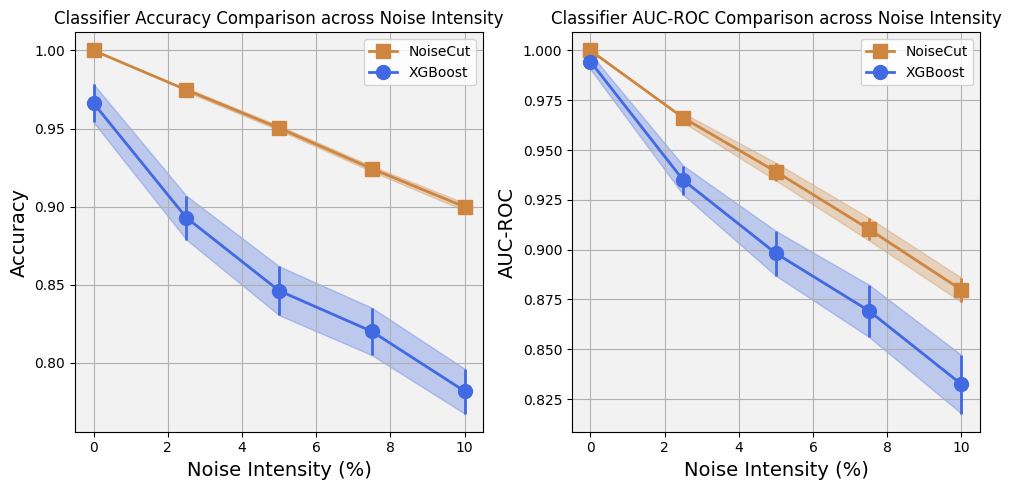

In [8]:
import matplotlib.pyplot as plt  # noqa: E402

# Set up the figure with subplots
fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(10, 5)
)  # Create a 1x2 grid of subplots

noise_list = [0, 2.5, 5, 7.5, 10]

# Set facecolor for both subplots
ax1.set_facecolor((0.95, 0.95, 0.95))
ax2.set_facecolor((0.95, 0.95, 0.95))

# error bars:
error_accuracy_NC = [
    (b - a) / 2 if not np.isnan(a) and not np.isnan(b) else np.nan
    for a, b in metric_dict_NC["accuracy"]["CIs"]
]
error_auc_NC = [
    (b - a) / 2 if not np.isnan(a) and not np.isnan(b) else np.nan
    for a, b in metric_dict_NC["auc"]["CIs"]
]

error_accuracy_XGB = [
    (b - a) / 2 if not np.isnan(a) and not np.isnan(b) else np.nan
    for a, b in metric_dict_XGB["accuracy"]["CIs"]
]
error_auc_XGB = [
    (b - a) / 2 if not np.isnan(a) and not np.isnan(b) else np.nan
    for a, b in metric_dict_XGB["auc"]["CIs"]
]

# Plots:
# NoiseCut Accuracy
ax1.errorbar(
    noise_list,
    metric_dict_NC["accuracy"]["medians"],
    yerr=error_accuracy_NC,
    marker="s",
    label="NoiseCut",
    linewidth=2,
    markersize=10,
    color="peru",
)
ax1.fill_between(
    noise_list,
    [
        x - y
        for x, y in zip(
            metric_dict_NC["accuracy"]["medians"], error_accuracy_NC
        )
    ],
    [
        x + y
        for x, y in zip(
            metric_dict_NC["accuracy"]["medians"], error_accuracy_NC
        )
    ],
    alpha=0.3,
    color="peru",
)

# XGBoost Accuracy
ax1.errorbar(
    noise_list,
    metric_dict_XGB["accuracy"]["medians"],
    yerr=error_accuracy_XGB,
    marker="o",
    label="XGBoost",
    linewidth=2,
    markersize=10,
    color="royalblue",
)
ax1.fill_between(
    noise_list,
    [
        x - y
        for x, y in zip(
            metric_dict_XGB["accuracy"]["medians"], error_accuracy_XGB
        )
    ],
    [
        x + y
        for x, y in zip(
            metric_dict_XGB["accuracy"]["medians"], error_accuracy_XGB
        )
    ],
    alpha=0.3,
    color="royalblue",
)

# NoiseCut AUC-ROC
ax2.errorbar(
    noise_list,
    metric_dict_NC["auc"]["medians"],
    yerr=error_auc_NC,
    marker="s",
    label="NoiseCut",
    linewidth=2,
    markersize=10,
    color="peru",
)
ax2.fill_between(
    noise_list,
    [x - y for x, y in zip(metric_dict_NC["auc"]["medians"], error_auc_NC)],
    [x + y for x, y in zip(metric_dict_NC["auc"]["medians"], error_auc_NC)],
    alpha=0.3,
    color="peru",
)

# XGBoost AUC-ROC
ax2.errorbar(
    noise_list,
    metric_dict_XGB["auc"]["medians"],
    yerr=error_auc_XGB,
    marker="o",
    label="XGBoost",
    linewidth=2,
    markersize=10,
    color="royalblue",
)
ax2.fill_between(
    noise_list,
    [x - y for x, y in zip(metric_dict_XGB["auc"]["medians"], error_auc_XGB)],
    [x + y for x, y in zip(metric_dict_XGB["auc"]["medians"], error_auc_XGB)],
    alpha=0.3,
    color="royalblue",
)

# Set common titles and labels for both subplots
ax1.set_title("Classifier Accuracy Comparison across Noise Intensity")
ax1.set_ylabel("Accuracy")
ax2.set_title("Classifier AUC-ROC Comparison across Noise Intensity")
ax2.set_ylabel("AUC-ROC")
for ax in [ax1, ax2]:
    ax.xaxis.label.set_fontsize(14)
    ax.yaxis.label.set_fontsize(14)
    ax.set_xlabel("Noise Intensity (%)")
    ax.legend(loc="upper right")
    ax.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

# Save the figure
# fig.savefig("./Performance Comparison.png", dpi=300)